In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [354]:
# load dataset
# https://www.kaggle.com/datasets/l3llff/banana?resource=download


# .sample(frac=1).reset_index(drop=True) shuffles the dataset
# this is important because the dataset is not ordered randomly
# without this, we lose a lot of information that is only caught in the test set
# surpisingly, the accuracy goes from ~0.3 to ~0.93 with this change

df = pd.read_csv(r'C:\data_sets\banana_quality.csv').sample(frac=1).reset_index(drop=True)

# check for data inconsistencies
print(f'There are {df.isnull().values.sum()} null values in the dataset')
df.info()
df.head()

There are 0 null values in the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float64
 5   Ripeness     8000 non-null   float64
 6   Acidity      8000 non-null   float64
 7   Quality      8000 non-null   object 
dtypes: float64(7), object(1)
memory usage: 500.1+ KB


,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,0.011879,-2.640471,-3.214326,-2.533397,2.889273,1.369996,0.843116,Good
1,0.096380,-1.551257,-2.358238,2.063821,2.693833,-0.317653,-0.019721,Good
2,-4.254969,-3.540650,-0.555481,-4.897400,-2.418439,0.792337,3.031604,Bad
3,-1.246533,-1.819733,-0.012945,0.940704,3.116719,1.559877,-1.343546,Good
4,-0.995066,-0.359774,1.587558,-3.014576,-1.050876,2.631204,3.052519,Good


In [355]:
# we map the quality column to 1 and 0 because we will be using the sigmoid activation
df["Quality"] = df["Quality"].map({"Good": 1, "Bad": 0})

# we will use the min-max normalization
df = (df - df.min()) / (df.max() - df.min())

In [356]:
# I'm setting up the data so each row is a training example and each column is a feature
# you can do the other way but this is more common as far as I've seen
class Data():
    def __init__(self, df):
        self.df = df
        self.train_X, self.train_y = np.array(df.drop("Quality", axis=1)[:6000]), np.array(df["Quality"][:6000]).reshape(6000,1)

        self.test_X, self.test_y = np.array(df.drop("Quality", axis=1)[6000:]), np.array(df["Quality"][6000:]).reshape(2000,1)

    def get_data(self):
        return self.train_X, self.train_y, self.test_X, self.test_y


In [406]:
train_X, train_y, test_X, test_y = Data(df).get_data()

In [407]:
# one hidden layer neural network
# sigmoid activation function

class Net():
    def __init__(self, data: 'Data', lr: float = 0.05, epochs: int = 100, hidden_nodes: int = 25):
        """
        Initialize the neural network. 

        data (Data): 
            The data object containing the dataset for training.
        lr (float): 
            Learning rate for the optimizer. Default is 0.01.
        epochs (int): 
            Number of training iterations (epochs). Default is 100.
        hidden_nodes (int): 
            Number of hidden nodes in the neural network. Default is 4.

        """

        # initialize some class variables to store info during training
        self.best_params = None
        self.best_accuracy = -1

        self.loss_memo = []
        self.test_accuracy_memo = []
        self.data = data
        self.lr = lr
        self.epochs = epochs
        self.hidden_nodes = hidden_nodes

        # init params
        # we need to init the weights randomly because if we set them to 0, they will all try to learn together
        # the biases can be set to 0 because they have no linear effect on y_pred, only additive

        self.w1 = np.random.rand(data.train_X.shape[1], hidden_nodes)
        self.b1 = np.zeros(hidden_nodes)
        self.w2 = np.random.rand(hidden_nodes, 1)
        self.b2 = np.zeros(1)

        
    def ReLu(self, x):
        return np.maximum(0, x)
    

    def ReLuDerivative(self, x):
        # derivative of ReLu activation function
        # there isn't too good of a way to write this mathematically
        return np.where(x <= 0, 0, 1)
    

    def sigmoid(self, x):
        # sigmoid activation function for binary classification
        return 1 / (1 + np.exp(-x))
    
    def forward_prop(self, X):

        w1 = self.w1
        w2 = self.w2
        b1 = self.b1
        b2 = self.b2

        self.z1 = np.dot(X,w1) + b1

        self.a1 = self.ReLu(self.z1)

        self.z2 = np.dot(self.a1, w2) + b2

        self.a2 = self.sigmoid(self.z2)

        # a2 is an array of our predictions
        # it's still a float but just round it to nearest int to get prediction
        return self.a2

        
    def cost(self, y, y_pred):
        # binary cross entropy cost function

        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    
    def back_prop(self, y, m):
        # the derivative of binary cross entropy loss function is conveniently y_pred - y

        dz2 = self.a2 - y

        # because we have a hidden layer its kinda like g(f(x)) where g is the second layer and f is the first layer
        # so we can use the chain rule to get the partial derivatives of the loss function
        # the actual derivatives are kinda boring and long so please just trust me that this is right

        # if it doesn't make sense that there are 6 derivatives, when there are only 4 sets of parameters we need to update
        # dz1 and dz2 are just temporary variables to make the code more readable
        # chain rule partial derivates get messy quickly without these


        dw2 = (1 / m) * np.dot(self.a1.T, dz2)

        db2 = (1 / m) * np.sum(dz2)

        dz1 = np.dot(dz2, self.w2.T) * self.ReLuDerivative(self.z1)

        dw1 = (1 / m) * np.dot(self.data.train_X.T, dz1)

        db1 = (1 / m) * np.sum(dz1)

        return dw1, dw2, db1, db2
    



    def update_params(self, dw1, dw2, db1, db2):
        self.w1 -= self.lr * dw1
        self.w2 -= self.lr * dw2
        self.b1 -= self.lr * db1
        self.b2 -= self.lr * db2
    
    def accuracy(self, y, y_pred):
        return np.mean(y == y_pred)


    def train(self):
        m = self.data.train_X.shape[0]
        
        self.metrics_df = pd.DataFrame(columns=['Epoch', 'Loss', 'Train Accuracy', 'Test Accuracy'])
        
        for epoch in range(self.epochs):

            # training cycle here
            y_pred = self.forward_prop(self.data.train_X)
            loss = self.cost(self.data.train_y, y_pred)
            dw1, dw2, db1, db2 = self.back_prop(self.data.train_y, m)
            self.update_params(dw1, dw2, db1, db2)
            acc = self.accuracy(self.data.train_y, np.round(y_pred))
            test_accuracy, test_loss = self.test()
            # ------------------------------


            new_row = pd.DataFrame({
                'Epoch': [epoch],
                'Loss': [loss],
                'Train Accuracy': [acc],
                'Test Accuracy': [test_accuracy],
                'Test Loss': [test_loss]

            })
            self.metrics_df = pd.concat([self.metrics_df, new_row], ignore_index=True)

            # Save loss and test accuracy to memos
            self.loss_memo.append(loss)
            self.test_accuracy_memo.append(test_accuracy)
            
            # Save best parameters
            if test_accuracy > self.best_accuracy:
                self.best_params = (self.w1, self.w2, self.b1, self.b2)
                self.best_accuracy = test_accuracy

    def test(self):
        # no dropout or batch norm so we don't need to think about that
        y_pred = self.forward_prop(self.data.test_X)
        accuracy = self.accuracy(self.data.test_y, np.round(y_pred))
        loss = self.cost(self.data.test_y, y_pred)
        return accuracy, loss

In [408]:
data = Data(df)
net = Net(data, epochs=10000)
net.train()

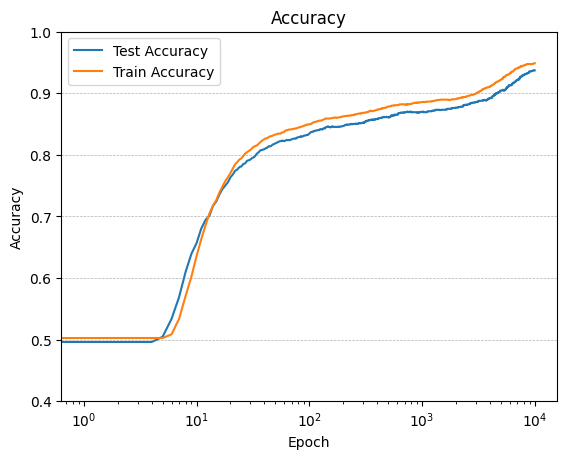

In [410]:
plt.plot(net.metrics_df["Test Accuracy"], label="Test Accuracy")
plt.plot(net.metrics_df["Train Accuracy"], label="Train Accuracy")
plt.xscale("log")

plt.yticks(np.arange(0.4, 1.1, step=0.1))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")

plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.grid(axis='y', which='minor', linestyle=':', linewidth=0.5)
plt.legend()
plt.show()


# while this is just a proof of concept
# there isn't much of an overfitting issue
# so, while it's pretty difficult to scale explicit architectures like this
# we could still probably get a couple more percent accuracy with more layers and nodes
# I also didn't tune any of the hyperparameters

